# import modules

In [2]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D,Concatenate,TimeDistributed
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn
warnings.filterwarnings('ignore')

# Load Features

In [127]:
alphabet_set=list(string.ascii_letters[:26])
alphabet_set.insert(0,'0')

## One-hot Encoding

# Models


In [128]:
X_gabor = np.load('.\\feature\\X_gabor.npy')
X_gabor_train,X_gabor_val= train_test_split(X_gabor,test_size=0.1,random_state=2019)
#X_gabor_train = np.load('./feature/X_gabor_train.npy')
#X_gabor_val = np.load('./feature/X_gabor_validation.npy')
X_mfcc= np.load('.\\feature\\X_feature.npy')
y_tone= np.load('.\\feature\\y_tone.npy')
X_mfcc_train,X_mfcc_val,y_tone_train,y_tone_val=train_test_split(X_mfcc,y_tone,test_size=0.1,random_state=2019)

In [129]:
#y_tone_train =np.load('.feature/y_tone_train.npy')
#y_tone_val =np.load('./feature/y_tone_validation.npy')

le=LabelEncoder()
y_tone_train=le.fit_transform(y_tone_train)
y_tone_val=le.fit_transform(y_tone_val)

CLASSES_LIST=le.classes_
print(CLASSES_LIST)

y_tone_train=to_categorical(y_tone_train,num_classes=4)
y_tone_val=to_categorical(y_tone_val,num_classes=4)


['1' '2' '3' '4']


In [130]:
y_tone_train.shape

(4233, 4)

In [131]:

y_tone_train = y_tone_train.reshape(4233,1,4)
y_tone_val = y_tone_val.reshape(471,1,4)
print(y_tone_val.shape)

(471, 1, 4)


In [132]:
#X_mfcc_train=np.load('./feature/fusion/mfcc_fusion_train.npy')
#X_mfcc_val=np.load('./feature/fusion/mfcc_fusion_validation.npy')

In [133]:
X_mfcc_train.shape

(4233, 50, 57)

In [3]:
NUM_CLASSES=4
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='.\models\early_merged_tone_cnn.h5'

In [4]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [123]:
def attention_model1():
    inputs2 = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs1)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
    output = Dense(200, activation='sigmoid')(attention_mul)
    #model = Model(inputs=[inputs], outputs=output)
    return output

def attention_model2():
    inputs1 = Input(shape=(35, 7))
    #x=BatchNormalization()(inputs)
    x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(inputs2)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=14,strides=4)(attention_mul)
    output = Dense(100, activation='sigmoid')(attention_mul)
    #model = Model(inputs=[inputs], outputs=output)
    return output

In [5]:
K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x=BatchNormalization()(inputs1)
x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
x = MaxPool1D()(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=14,strides=4)(attention_mul)
out_gabor = Dense(100, activation='sigmoid')(attention_mul)


inputs2=Input(shape=(50,57),name='inputs_mfcc')
x = BatchNormalization()(inputs2)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
x = Dropout(0.3)(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
out_mfcc = Dense(200, activation='sigmoid')(attention_mul)

merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
inputs_mfcc (InputLayer)        [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 35, 7)        28          inputs_gabor[0][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 57)       228         inputs_mfcc[0][0]                
_______________________________________________________________________________________

K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x=BatchNormalization()(inputs1)
x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
x = MaxPool1D()(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=14,strides=4)(attention_mul)
output = Dense(60, activation='sigmoid')(attention_mul)
x=output
out_gabor = x
#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)


inputs2=Input(shape=(50,57),name='inputs_mfcc')
x = BatchNormalization()(inputs2)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
x = Dropout(0.3)(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
output = Dense(200, activation='sigmoid')(attention_mul)
out_mfcc= output


merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.5)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()


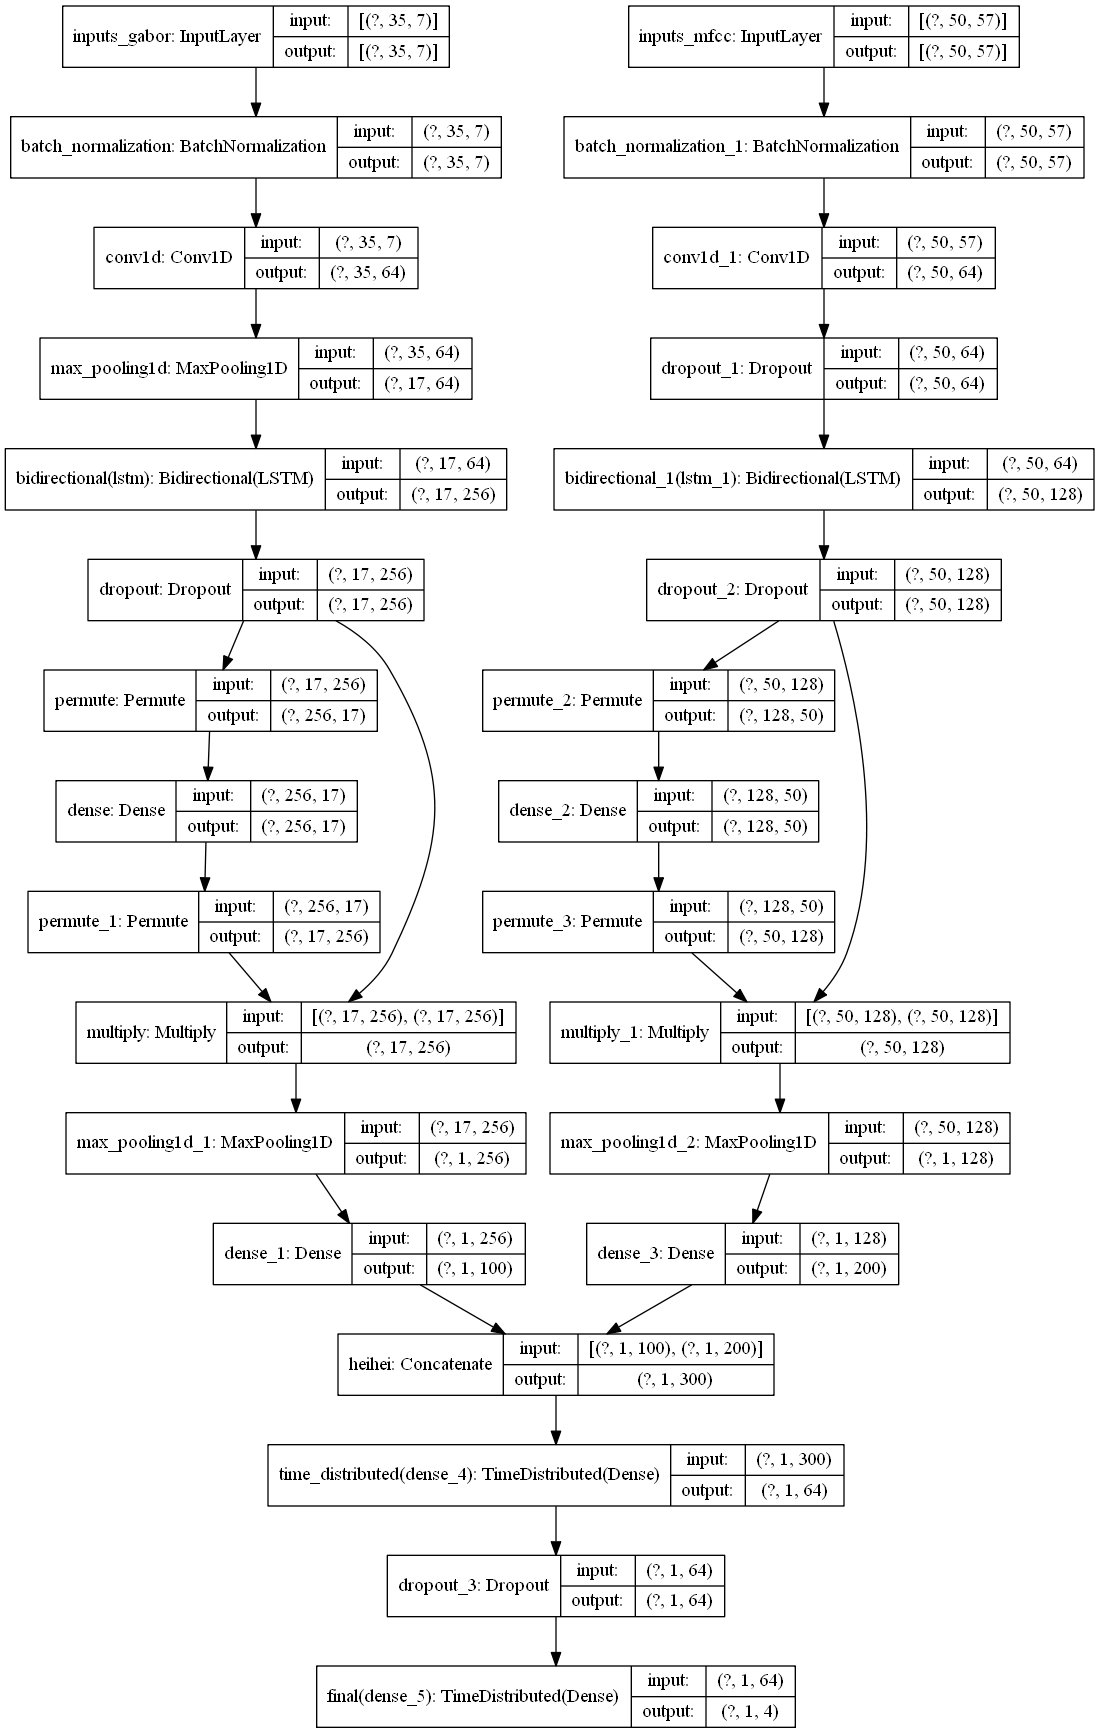

In [7]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(merged_model, to_file='.\\Fusion_tone.png', show_shapes=True)

In [140]:
from keras import optimizers
adam=optimizers.Adam(learning_rate=0.001)

In [141]:

merged_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(merged_model,'merged_model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=merged_model.fit(x=[X_gabor_train,X_mfcc_train],y=y_tone_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=([X_gabor_val,X_mfcc_val],y_tone_val),
                  callbacks=callback_list)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 1.4423 - accuracy: 0.2755
Epoch 00001: val_accuracy improved from -inf to 0.27176, saving model to .\models\early_merged_tone_cnn.h5
34/34 [==============================] - 12s 352ms/step - loss: 1.4423 - accuracy: 0.2755 - val_loss: 1.4335 - val_accuracy: 0.2718
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 1.2992 - accuracy: 0.3692
Epoch 00002: val_accuracy improved from 0.27176 to 0.39278, saving model to .\models\early_merged_tone_cnn.h5
34/34 [==============================] - 11s 312ms/step - loss: 1.2992 - accuracy: 0.3692 - val_loss: 1.2529 - val_accuracy: 0.3928
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.4893
Epoch 00003: val_accuracy improved from 0.39278 to 0.55414, saving model to .\models\early_merged_tone_cnn.h5
34/34 [==============================] - 11s 309ms/step - loss: 1.1522 - accuracy: 0.4893 - val_loss: 1.0127 - val_accuracy:

In [ ]:
K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')


x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs1)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs1)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs1)
x_3=MaxPool1D()(x_3)
#x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs)
#x_4=MaxPool1D()(x_4)
#x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs)
#x_5=MaxPool1D()(x_5)
#short_cut=Conv1D(filters=448,kernel_size=19,padding='valid')(inputs)
x=Concatenate()([x_1,x_2,x_3])

#x=Add()([x,short_cut])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=16,name='gabor')(x)

out_gabor = MaxPool1D(name='output_gabor')(x)



#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)

inputs2=Input(shape=(50,57),name='inputs_mfcc')
x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(inputs2)
x=Bidirectional(LSTM(100,dropout=0.25),name='ooo')(x)
out_mfcc= Reshape((1,200))(x)


merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

In [22]:
x = attention_model2()

In [23]:
x

1

In [112]:
x = attention_model2()
x = BatchNormalization()(x)
out_gabor = x
#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)
x = attention_model2()
out_mfcc= BatchNormalization()(x)


merged_layer= Concatenate(name='heihei')([out_mfcc,out_gabor])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_mfcc (InputLayer)        [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 50, 64)       3712        inputs_mfcc[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       3712        inputs_mfcc[0][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 25, 64)       0           conv1d_3[0][0]                   
_______________________________________________________________________________________

In [28]:
NUM_CLASSES=4
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/early_merged_tone_cnn.h5'

K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')


x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs1)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs1)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs1)
x_3=MaxPool1D()(x_3)
#x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs)
#x_4=MaxPool1D()(x_4)
#x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs)
#x_5=MaxPool1D()(x_5)
#short_cut=Conv1D(filters=448,kernel_size=19,padding='valid')(inputs)
x=Concatenate()([x_1,x_2,x_3])

#x=Add()([x,short_cut])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=16,name='gabor')(x)

out_gabor = MaxPool1D(name='output_gabor')(x)



#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)

inputs2=Input(shape=(50,57),name='inputs_mfcc')
x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(inputs2)
x=Bidirectional(LSTM(100,dropout=0.25),name='ooo')(x)
out_mfcc= Reshape((1,200))(x)


merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 35, 64)       1408        inputs_gabor[0][0]               
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 128)      7296        inputs_gabor[0][0]               
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 256)      23552       inputs_gabor[0][0]               
_______________________________________________________________________________________

In [25]:

merged_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(merged_model,'merged_model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=merged_model.fit(x=[X_gabor_train,X_mfcc_train],y=y_tone_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=([X_gabor_val,X_mfcc_val],y_tone_val),
                  callbacks=callback_list)

Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 1.3468 - accuracy: 0.4600
Epoch 00001: val_accuracy improved from -inf to 0.42038, saving model to ./models\early_merged_tone_cnn.h5
34/34 [==============================] - 9s 261ms/step - loss: 1.3481 - accuracy: 0.4600 - val_loss: 1.6484 - val_accuracy: 0.4204
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 1.0069 - accuracy: 0.5919
Epoch 00002: val_accuracy improved from 0.42038 to 0.46072, saving model to ./models\early_merged_tone_cnn.h5
34/34 [==============================] - 7s 217ms/step - loss: 1.0063 - accuracy: 0.5920 - val_loss: 1.4977 - val_accuracy: 0.4607
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 0.8263 - accuracy: 0.6768
Epoch 00003: val_accuracy improved from 0.46072 to 0.54565, saving model to ./models\early_merged_tone_cnn.h5
34/34 [==============================] - 7s 206ms/step - loss: 0.8259 - accuracy: 0.6771 - val_loss: 1.1495 - val_accuracy: 0.

KeyboardInterrupt: 

## plot_curve

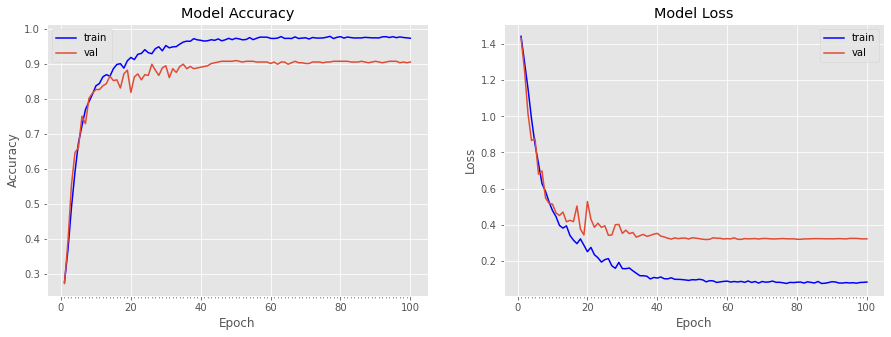

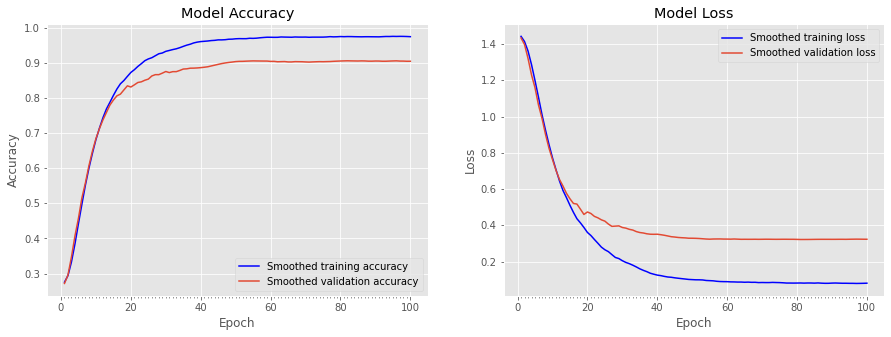

In [142]:
from help import plot_curve,plot_curve_with_smooth
%matplotlib inline 
plot_curve(history)
plot_curve_with_smooth(history)

## confusion_metrix

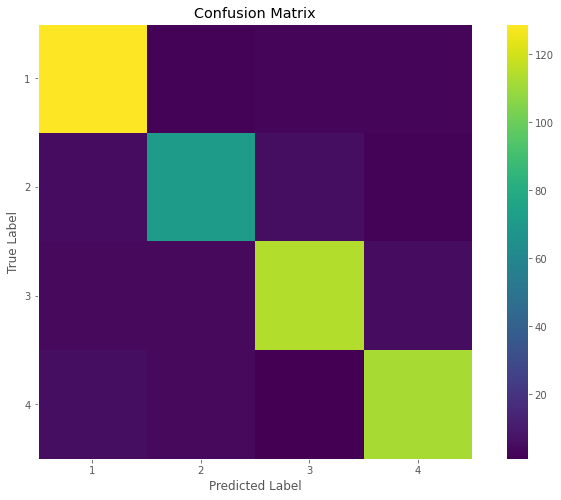

In [143]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=merged_model.predict([X_gabor_val,X_mfcc_val])
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_tone_val,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
#target_names=[alphabet_set[i] for i in range(4)]
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = [1,2,3,4]
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [144]:
from sklearn.metrics import classification_report

target_names = ['1', '2', '3','4']
print(classification_report(y_true,y_pred,digits=4,labels=[0,1,2,3],target_names=target_names))

              precision    recall  f1-score   support

           1     0.8958    0.9416    0.9181       137
           2     0.8765    0.8452    0.8606        84
           3     0.9194    0.8976    0.9084       127
           4     0.9180    0.9106    0.9143       123

    accuracy                         0.9045       471
   macro avg     0.9024    0.8988    0.9004       471
weighted avg     0.9045    0.9045    0.9042       471



# predict test

In [14]:
merged_model.load_weights(MODEL_SAVE_PATH)


In [16]:
alphabet_set = {0:'1',1:'2',2:'3',3:'4'}

In [18]:
ID = 'person10_time1_group2_zhong_1'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)


test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:1


In [19]:
ID = 'person6_time1_group1_ge_4'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:4
